In [1]:
from functools import partial
import itertools
import json
from pathlib import Path
import re
import sys
sys.path.append("../src")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from tqdm import tqdm, tqdm_notebook

%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette("muted")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
#set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

In [2]:
# Path to decoder results
decoder_path = Path("../models/decoders")
bert_encoding_path = Path("../models/bert")

In [3]:
sprobe_results_path = Path("~/om2/others/structural-probes/bert").expanduser()

In [4]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
bert_models = ["_", "SQuAD", "QQP", "MNLI", "SST", "LM", "LM_lmonly", "LM_scrambled_para", "LM_scrambled", "LM_lmonly_scrambled", "LM_contentonly", "LM_contentonly_scrambled", "LM_randommask", "LM_pos"]
# Models which should appear in the final report figures
report_models = ["SQuAD", "QQP", "MNLI", "SST", "LM", "LM_scrambled", "LM_pos"]
checkpoint_steps = list(range(5,255,5))
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-250"
target_runs = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [5]:
RENDER_FINAL = False
figure_path = Path("../reports/figures")
figure_path.mkdir(exist_ok=True)

### Collect results

In [6]:
eval_results = {}
for eval_dir in tqdm_notebook(list(sprobe_results_path.glob("%s.%s.*" % (finetune_desc, bert_base_model)))):
    if not eval_dir.is_dir(): continue
    try:
        model, run, step, layer = re.findall(r"\.([\w_]+)-run(\d+)-(\d+)-layer(\d+)$", eval_dir.name)[0]
    except IndexError: continue
    run, step, layer = int(run), int(step), int(layer)
    
    try:
        uuas_file = list(eval_dir.glob("**/dev.uuas"))[0]
        with uuas_file.open("r") as f:
            uuas = float(f.read().strip())
    except: continue
        
    try:
        spearman_file = list(eval_dir.glob("**/dev.spearmanr-*-mean"))[0]
        with spearman_file.open("r") as f:
            spearman = float(f.read().strip())
    except: continue
        
    eval_results[model, run, step, layer] = pd.Series({"uuas": uuas, "spearman": spearman})
    
eval_results = pd.DataFrame(pd.concat(eval_results, names=["model", "run", "step", "layer", "metric"]))
eval_results.head()

0
model run step layer metric            
LM    1   5    0     uuas      0.437213
                     spearman  0.603449
               6     uuas      0.475018
                     spearman  0.674427
               11    uuas      0.400123

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


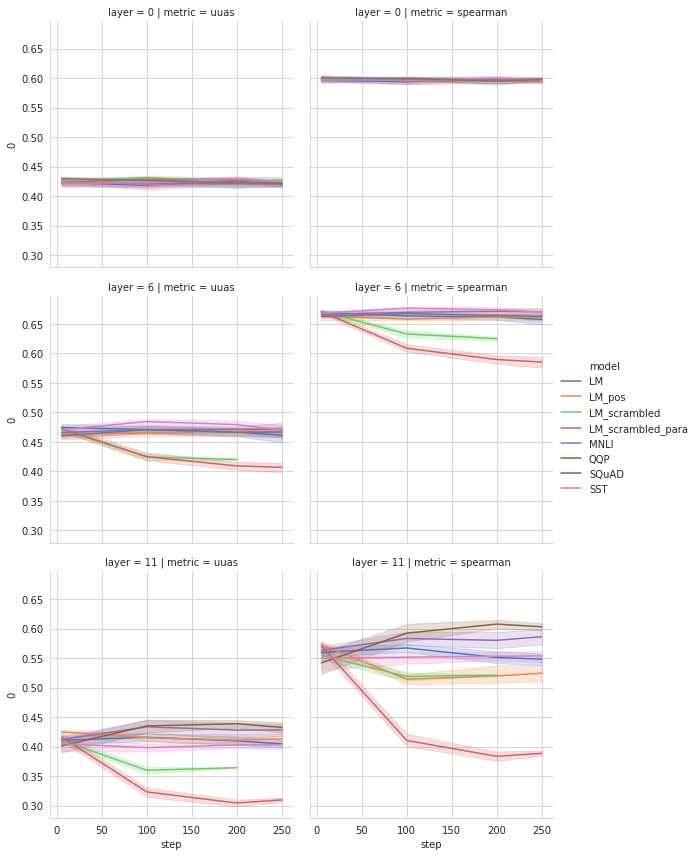

In [7]:
g = sns.FacetGrid(data=eval_results.reset_index(), col="metric", row="layer", height=4, sharex=True, sharey=True)
g.map(sns.lineplot, "step", 0, "model").add_legend()

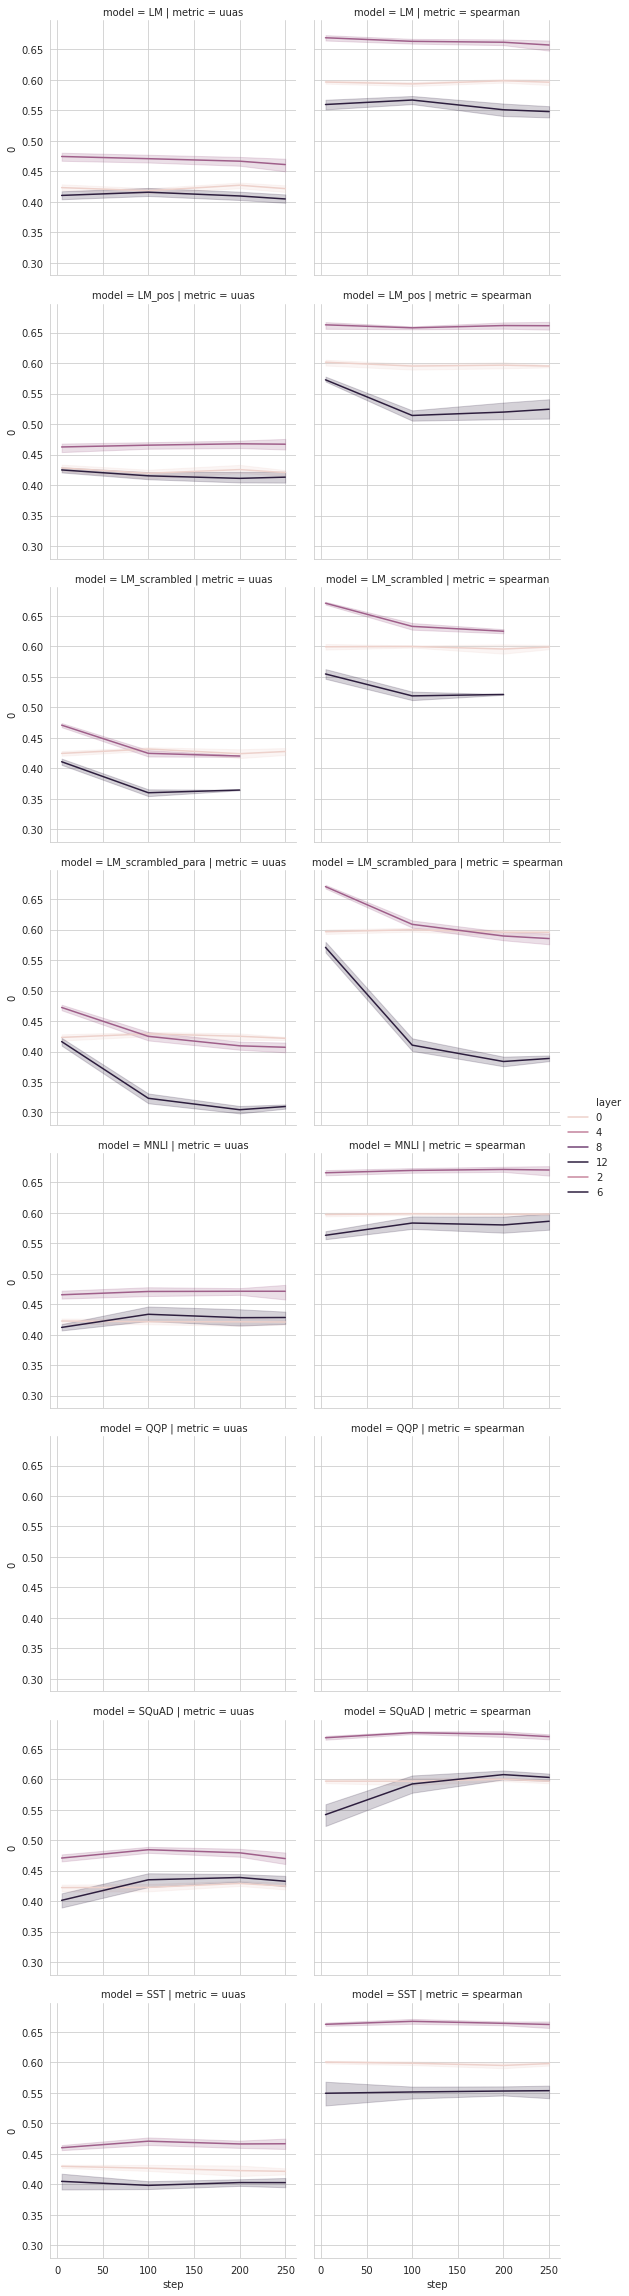

In [8]:
g = sns.FacetGrid(data=eval_results.reset_index(), col="metric", row="model", height=4, sharex=True, sharey=True)
g.map(sns.lineplot, "step", 0, "layer").add_legend()

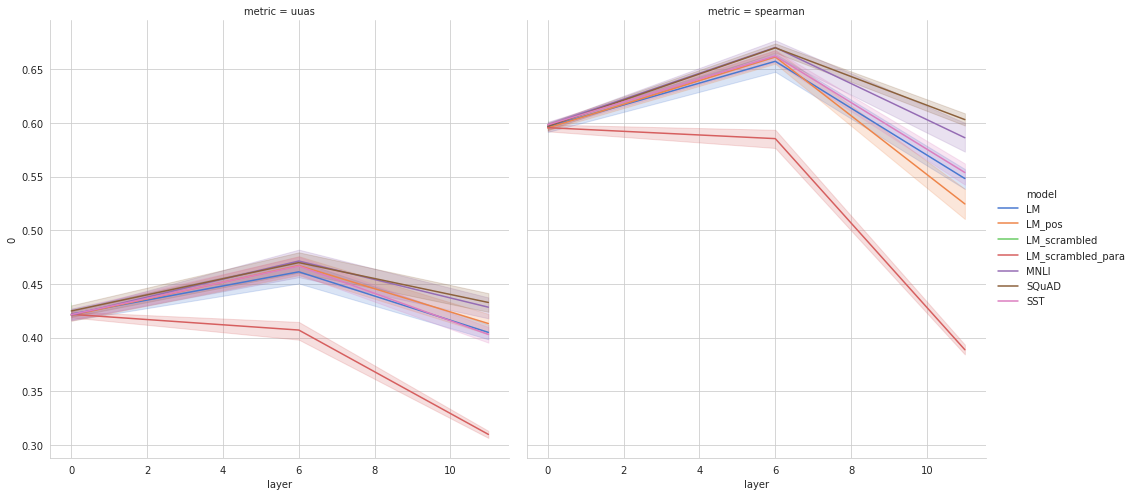

In [9]:
data = eval_results.reset_index()
g = sns.FacetGrid(data=data[data.step == checkpoint_steps[-1]], col="metric", height=7, sharex=True, sharey=True)
g.map(sns.lineplot, "layer", 0, "model").add_legend()

In [10]:
%matplotlib agg

if RENDER_FINAL:
    dir = figure_path / "structural_probe"
    dir.mkdir(exist_ok=True)
    
    for metric in ["uuas", "spearman"]:
        fig = plt.figure(figsize=(10, 10))
        df = eval_results.reset_index()
        sns.lineplot(data=df[df.metric == metric], x="step", y=0, hue="model")
        plt.ylabel(metric)
        plt.tight_layout()
        plt.savefig(dir / ("%s.png" % metric))
        plt.close()
    
%matplotlib inline